In [105]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate
import pyfits
import plotc
import read_params
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
def plot_surface(arr):
    plotc.colorplot(arr,x=x,y=z,yr=[-7,None],xr=[-70,70],sp=next(gl),centerzero=True);

nx: 256 Lx: 200.0
True psi file: true_psi.fits


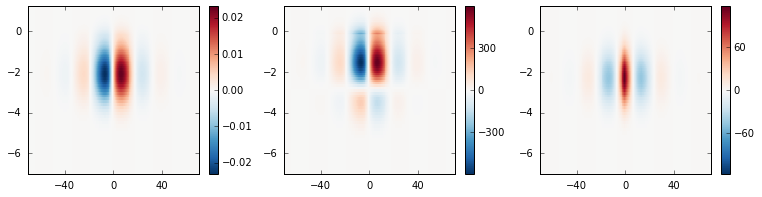

In [107]:
Lx = read_params.get_xlength()
nx = read_params.get_nx()
nz = read_params.get_nz()
print("nx:",nx,"Lx:",Lx)
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun=695.8
z = np.loadtxt(read_params.get_solarmodel(),usecols=[0]); z=(z-1)*Rsun
print("True psi file:",read_params.get_true_psi_filename())
psi_true = np.squeeze(pyfits.getdata(read_params.get_true_psi_filename()))
vx_true = np.squeeze(pyfits.getdata(read_params.get_true_vx_filename()))
vz_true = np.squeeze(pyfits.getdata(read_params.get_true_vz_filename()))
print
gl = plotc.gridlist(1,3)
plot_surface(psi_true);
plot_surface(vx_true);
plot_surface(vz_true);
plt.gcf().set_size_inches(13,3);

### Load true and model coeff

In [108]:
x_cutoff = 50; z_cutoff = -6 # Mm
xspline_index = abs(x)<x_cutoff
xspline_index_int = np.where(xspline_index)[0]
xspline = x[xspline_index]
zspline_index = z>z_cutoff
zspline_index_int = np.where(zspline_index)[0]
zspline = z[zspline_index]

xspline_index_mgrid = np.array([xspline_index_int for _ in zspline_index_int])
zspline_index_mgrid = np.array([[zj]*len(xspline_index_int) for zj in zspline_index_int])
spline_ind_1D = np.ravel_multi_index([zspline_index_mgrid.flatten(),
                            xspline_index_mgrid.flatten()],(nz,nx))

xspline_coord_mgrid = np.array([xspline for _ in zspline_index_int])
zspline_coord_mgrid = np.array([[zj]*len(xspline) for zj in zspline])

coeff_surf_cutoff_ind = 10

In [109]:
def coeff_to_model(coeffs):
    model = interpolate.bisplev(xspline,zspline,(tx_ref,tz_ref,coeffs,kx_ref,kz_ref))
    model_fullsize = np.zeros_like(psi_true)
    model_fullsize.put(spline_ind_1D,model.T.flatten())
    return model_fullsize

def model_to_coeff(model):
    model_spline = model[zspline_index][:,xspline_index]
    return interpolate.bisplrep(xspline_coord_mgrid.flatten(),
                    zspline_coord_mgrid.flatten(),model_spline.flatten(),kx=3,ky=2,s=1e-4)

In [120]:
datadir = read_params.get_directory()
true_coeffs_file = os.path.join(datadir,"true_psi_coeffs.npz")
with np.load(true_coeffs_file) as f:
    tx_ref = f["tx"]
    tz_ref = f["tz"]
    c_ref_above_surface = f["c_upper"]
    c_ref_below_surface = f["c_lower"]
    kx_ref = f["kx"]
    kz_ref = f["kz"]
iterno = 5
model_coeffs_file = os.path.join(datadir,"update","model_psi_"+str(iterno).zfill(2)+"_coeffs.npz")
with np.load(model_coeffs_file) as f:
    c_model_below_surface = f["c_lower"]
    back_model = f["back"]
    
spl_c_shape_xz_2D = (len(tx_ref)-kx_ref-1,len(tz_ref)-kz_ref-1)

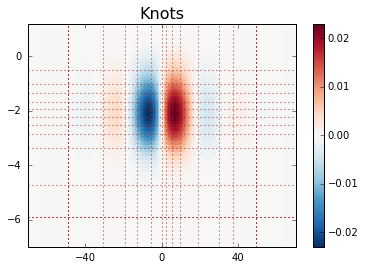

In [136]:
gl=plotc.gridlist(1,1)
plot_surface(psi_true);
for t in tx_ref: plt.axvline(t,color="brown",ls="dotted")
for t in tz_ref: plt.axhline(t,color="brown",ls="dotted")
plt.title("Knots",fontsize=16);

In [ ]:
plt.plot(c_ref_above_surface+c_ref_below_surface,'o-',markersize=3,color="c")
plt.plot(c_ref_above_surface+c_model_below_surface,'o-',markersize=3,color="r")
for i in [(len(tz_ref)-kz_ref-1)*i for i in xrange(1,len(tx_ref)-kx_ref)]:
    plt.axvline(i,ls="dotted",color="black")
plt.xlim(0,(len(tz_ref)-kz_ref-1)*(len(tx_ref)-kx_ref-1));
plt.gcf().set_size_inches(8,5);

Vertical lines indicate x knots, in each x knot the left edge indicates deep z knots and right edge indicates surface z knots

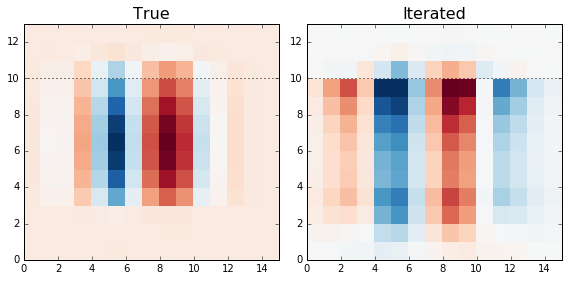

In [122]:
gl = plotc.gridlist(1,2)
plt.subplot(next(gl))
plt.pcolormesh((c_ref_above_surface+c_ref_below_surface).reshape(spl_c_shape_xz_2D).T,
cmap="RdBu_r")
plt.xlim(0,spl_c_shape_xz_2D[0])
plt.ylim(0,spl_c_shape_xz_2D[1])
plt.axhline(10,ls="dotted",color="black")
plt.title("True",fontsize=16)

plt.subplot(next(gl))
vmax = (c_ref_above_surface+c_ref_below_surface).max()
plt.pcolormesh((c_ref_above_surface+c_model_below_surface).reshape(spl_c_shape_xz_2D).T,
cmap="RdBu_r",vmax=vmax,vmin=-vmax)

plt.axhline(10,ls="dotted",color="black")
plt.xlim(0,spl_c_shape_xz_2D[0])
plt.ylim(0,spl_c_shape_xz_2D[1])
plt.title("Iterated",fontsize=16)

plt.gcf().set_size_inches(8,4)
plt.tight_layout()

## Iterated psi

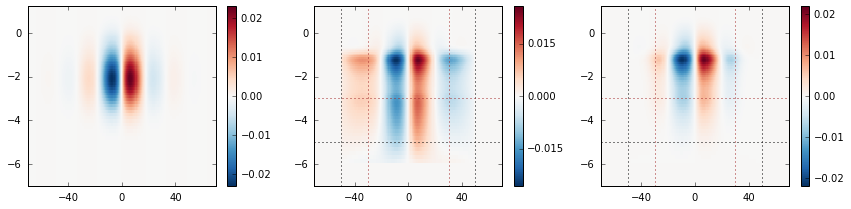

In [129]:
gl=plotc.gridlist(1,3)
plot_surface(psi_true)
plot_surface(coeff_to_model(c_ref_above_surface+c_model_below_surface))
plt.axvline(-50,color="black",ls="dotted")
plt.axvline(50,color="black",ls="dotted")
plt.axvline(-30,color="brown",ls="dotted")
plt.axvline(30,color="brown",ls="dotted")
plt.axhline(-5,color="black",ls="dotted")
plt.axhline(-3,color="brown",ls="dotted")
psi_iter = pyfits.getdata(os.path.join(datadir,"update","model_psi_"+str(iterno).zfill(2)+".fits"))
plot_surface(psi_iter-back_model)
plt.axvline(-50,color="black",ls="dotted")
plt.axvline(50,color="black",ls="dotted")
plt.axvline(-30,color="brown",ls="dotted")
plt.axvline(30,color="brown",ls="dotted")
plt.axhline(-5,color="black",ls="dotted")
plt.axhline(-3,color="brown",ls="dotted")
plt.gcf().set_size_inches(12,3)
plt.tight_layout()

## Velocities

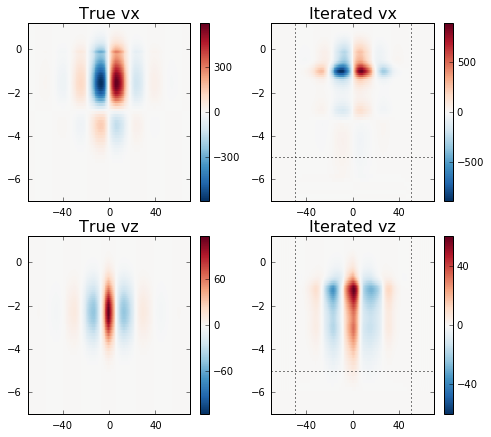

In [124]:
gl=plotc.gridlist(2,2)
plot_surface(vx_true)
plt.title("True vx",fontsize=16)
vx_iter = pyfits.getdata(os.path.join(datadir,"update","vx_"+str(iterno).zfill(2)+".fits"))
plot_surface(vx_iter)
plt.title("Iterated vx",fontsize=16)
plt.axvline(-50,color="black",ls="dotted")
plt.axvline(50,color="black",ls="dotted")
plt.axhline(-5,color="black",ls="dotted")
plot_surface(vz_true)
plt.title("True vz",fontsize=16)
vz_iter = pyfits.getdata(os.path.join(datadir,"update","vz_"+str(iterno).zfill(2)+".fits"))
plot_surface(vz_iter)
plt.axvline(-50,color="black",ls="dotted")
plt.axvline(50,color="black",ls="dotted")
plt.axhline(-5,color="black",ls="dotted")
plt.title("Iterated vz",fontsize=16)
plt.gcf().set_size_inches(8,7)

In [125]:
print("vx true max {:.1f}, vx iter max {:.1f}".format(abs(vx_true).max(),abs(vx_iter).max()))
print("vz true max {:.1f}, vz iter max {:.1f}".format(abs(vz_true).max(),abs(vz_iter).max()))

vx true max 595.4, vx iter max 880.3
vz true max 116.8, vz iter max 60.4
